In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time


In [45]:
import numpy as np

def euclidean_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def read_tsp_file(file_path):
    """Read a .tsp file and extract the coordinates as a NumPy array."""
    coordinates = []
    with open(file_path, 'r') as file:
        # Skip the header
        while True:
            line = file.readline()
            if line.strip() == "NODE_COORD_SECTION":
                break
        # Read the coordinates
        for line in file:
            if line.strip() == "EOF":
                break
            _, x, y = line.strip().split()
            coordinates.append([float(x), float(y)])
    return np.array(coordinates)

def calculate_distance_matrix(coordinates):
    """Calculate a distance matrix given coordinates."""
    n = len(coordinates)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                distance_matrix[i][j] = euclidean_distance(coordinates[i], coordinates[j])
            else:
                # Optionally, set diagonal to a high value or keep as 0, knowing it won't be used directly
                distance_matrix[i][j] = 0 # This line is optional; adjust based on your algorithm's needs
    return distance_matrix

# Replace 'file_path' with your actual path to the .tsp file
file_path = r'C:\Users\manue\Downloads\dj38.tsp'

coordinates = read_tsp_file(file_path)
cities = coordinates  # Ensuring cities are defined for later use
print("Coordinates:\n", coordinates)

# Calculate the distance matrix
distance_matrix = calculate_distance_matrix(coordinates)
print("Distance Matrix:\n", distance_matrix)


Coordinates:
 [[11003.6111 42102.5   ]
 [11108.6111 42373.8889]
 [11133.3333 42885.8333]
 [11155.8333 42712.5   ]
 [11183.3333 42933.3333]
 [11297.5    42853.3333]
 [11310.2778 42929.4444]
 [11416.6667 42983.3333]
 [11423.8889 43000.2778]
 [11438.3333 42057.2222]
 [11461.1111 43252.7778]
 [11485.5556 43187.2222]
 [11503.0556 42855.2778]
 [11511.3889 42106.3889]
 [11522.2222 42841.9444]
 [11569.4444 43136.6667]
 [11583.3333 43150.    ]
 [11595.     43148.0556]
 [11600.     43150.    ]
 [11690.5556 42686.6667]
 [11715.8333 41836.1111]
 [11751.1111 42814.4444]
 [11770.2778 42651.9444]
 [11785.2778 42884.4444]
 [11822.7778 42673.6111]
 [11846.9444 42660.5556]
 [11963.0556 43290.5556]
 [11973.0556 43026.1111]
 [12058.3333 42195.5556]
 [12149.4444 42477.5   ]
 [12286.9444 43355.5556]
 [12300.     42433.3333]
 [12355.8333 43156.3889]
 [12363.3333 43189.1667]
 [12372.7778 42711.3889]
 [12386.6667 43334.7222]
 [12421.6667 42895.5556]
 [12645.     42973.3333]]
Distance Matrix:
 [[   0.          

In [46]:
import numpy as np
import matplotlib.pyplot as plt

class ACO:
    def __init__(self, distance_matrix, num_ants, num_iterations, decay, alpha, beta, stagnation_limit=20):
        self.distance_matrix = distance_matrix
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.stagnation_limit = 30
        self.pheromone = np.ones(distance_matrix.shape) / len(distance_matrix)
        self.completed_iterations = 0
        self.best_distance = float('inf')
        self.best_distance_history = []  # To store the best distance found in each iteration
        
    def run(self):
        shortest_path = None
        stagnation_counter = 0
        
        for _ in range(self.num_iterations):
            paths = self.generate_paths()
            self.update_pheromone(paths)
            shortest_path_this_iteration, distance = min(paths, key=lambda x: x[1])
            if distance < self.best_distance:
                self.best_distance = distance
                shortest_path = shortest_path_this_iteration
                stagnation_counter = 0
            else:
                stagnation_counter += 1
            
            self.best_distance_history.append(self.best_distance)  # Record best distance for this iteration
            
            if stagnation_counter >= self.stagnation_limit:
                print(f"Stopping early due to stagnation after {self.completed_iterations} iterations.")
                break
            
            self.completed_iterations += 1
        
        return shortest_path, self.best_distance
    
    def generate_paths(self):
        paths = []
        for _ in range(self.num_ants):
            path = self.generate_path()
            distance = self.path_distance(path)
            paths.append((path, distance))
        return paths
    
    def generate_path(self):
        path = [np.random.randint(len(self.distance_matrix))]
        while len(path) < len(self.distance_matrix):
            next_city = self.select_next_city(path[-1], path)
            path.append(next_city)
        return path
    
    def select_next_city(self, current_city, path):
        probabilities = self.transition_probabilities(current_city, path)
        next_city = np.random.choice(range(len(self.distance_matrix)), p=probabilities)
        return next_city
    
    def transition_probabilities(self, current_city, path):
        pheromone = np.power(self.pheromone[current_city], self.alpha)
        heuristic = np.power(1.0 / (self.distance_matrix[current_city] + 1e-10), self.beta)  # Avoid division by zero
        mask = np.ones(len(self.distance_matrix), dtype=bool)  # True means city is available
        mask[path] = False  # Set visited cities to False
        probabilities = pheromone * heuristic * mask
        return probabilities / probabilities.sum()
    
    def update_pheromone(self, paths):
        self.pheromone *= (1 - self.decay)  # Evaporation
        for path, distance in paths:
            for i in range(len(path) - 1):
                self.pheromone[path[i]][path[i + 1]] += 1.0 / distance
    
    def path_distance(self, path):
        return sum([self.distance_matrix[path[i], path[i+1]] for i in range(-1, len(path) - 1)])


Stopping early due to stagnation after 73 iterations.
Best route found: [8, 7, 6, 5, 4, 2, 3, 1, 0, 9, 13, 20, 28, 29, 31, 34, 36, 37, 32, 33, 35, 30, 26, 27, 23, 21, 24, 25, 22, 19, 14, 12, 15, 17, 18, 16, 11, 10]
Total distance of the best route: 6663.213801224397
Execution time: 2.0644803047180176 seconds


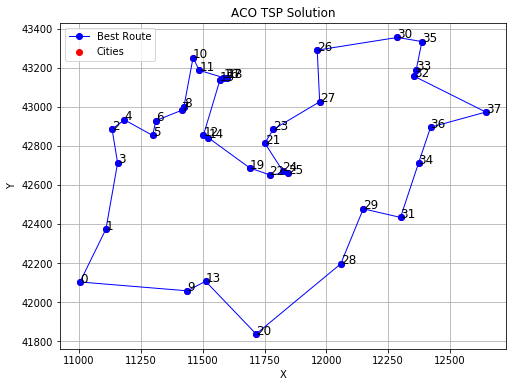

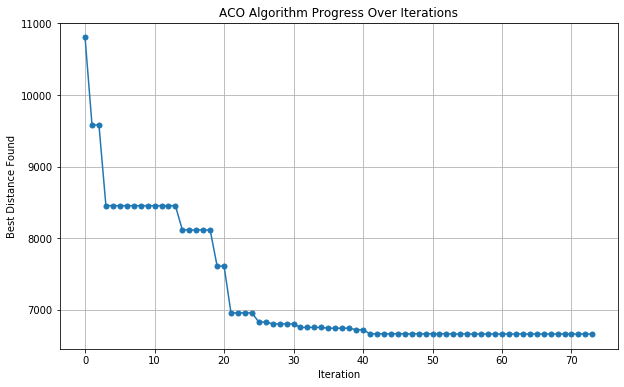

In [60]:
# Start measuring time
start_time = time.time()

# Initialize the ACO algorithm with the necessary parameters
aco = ACO(distance_matrix=distance_matrix,  # Ensure distance_matrix is defined as shown before
          num_ants=15, 
          num_iterations=100, 
          decay=0.25, 
          alpha=1, 
          beta=2.5)

# Run the ACO algorithm
best_route, best_distance = aco.run()

# Measure the execution time
end_time = time.time()
duration = end_time - start_time

print("Best route found:", best_route)
print("Total distance of the best route:", best_distance)
print(f"Execution time: {duration} seconds")

# Visualization
plt.figure(figsize=(8, 6))
# Assuming 'cities' is an array of coordinates in the same order as in the distance matrix
plt.scatter(cities[:,0], cities[:,1], color='red', label='Cities')
for i in range(len(cities)):
    plt.annotate(i, (cities[i,0]+0.1, cities[i,1]+0.1), fontsize=12)
# Convert best_route indexes to city coordinates
best_route_cities = np.array([cities[i] for i in best_route])
# Ensure the path is closed by returning to the start
best_route_cities = np.vstack([best_route_cities, best_route_cities[0]])
plt.plot(best_route_cities[:,0], best_route_cities[:,1], color='blue', marker='o', linestyle='-', linewidth=1, markersize=6, label='Best Route')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('ACO TSP Solution')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the progress of the solution
plt.figure(figsize=(10, 6))
plt.plot(aco.best_distance_history, marker='o', linestyle='-', markersize=5)
plt.title('ACO Algorithm Progress Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Best Distance Found')
plt.grid(True)
plt.show()


In [65]:
import numpy as np

# Assume the ACO class is defined as in the previous instructions,
# including modifications for tracking stagnation and plotting progress if needed.

# Optimal TSP result for comparison (you might need to adjust this value according to your TSP instance)
optimal_result = 6656

# Define ranges for hyperparameters
alpha_values = [0.5, 1, 1.5]
beta_values = [2, 2.5, 3]
decay_values = [0.1, 0.5, 0.9]
num_ants_values = [10, 20, 30]
num_iterations_values = [50, 100, 150]

# Initialize results dictionary
results = {}

# Experiment loop
for alpha in alpha_values:
    for beta in beta_values:
        for decay in decay_values:
            for num_ants in num_ants_values:
                for num_iterations in num_iterations_values:
                    key = (num_ants, num_iterations, alpha, beta, decay)
                    results[key] = {'distances': [], 'performance_diffs': []}
                    for _ in range(5):  # Adjust number of runs per configuration if necessary
                        aco = ACO(distance_matrix=distance_matrix, num_ants=num_ants, num_iterations=num_iterations,
                                  decay=decay, alpha=alpha, beta=beta)
                        _, best_distance = aco.run()
                        results[key]['distances'].append(best_distance)
                        perf_diff = ((best_distance - optimal_result) / optimal_result) * 100
                        results[key]['performance_diffs'].append(perf_diff)

# Calculate statistics and save or print results
for key, value in results.items():
    distances = np.array(value['distances'])
    perf_diffs = np.array(value['performance_diffs'])
    avg_distance = np.mean(distances)
    std_dev_distance = np.std(distances)
    avg_perf_diff = np.mean(perf_diffs)
    std_dev_perf_diff = np.std(perf_diffs)
    # Printing results
    print(f"Num Ants: {key[0]}, Num Iterations: {key[1]}, Alpha: {key[2]}, Beta: {key[3]}, Decay: {key[4]}, "
          f"Average Distance: {avg_distance:.2f}, Std. Dev. Distance: {std_dev_distance:.2f}, "
          f"Average Performance Diff.: {avg_perf_diff:.2f}%, Std. Dev. Performance Diff.: {std_dev_perf_diff:.2f}%")


with open('aco_tsp_hyperparameter_study_results.txt', 'w') as file:
    for key, value in results.items():
        distances = np.array(value['distances'])
        perf_diffs = np.array(value['performance_diffs'])
        avg_distance = np.mean(distances)
        std_dev_distance = np.std(distances)
        avg_perf_diff = np.mean(perf_diffs)
        std_dev_perf_diff = np.std(perf_diffs)
        # Writing results to file
        file.write(f"Num Ants: {key[0]}, Num Iterations: {key[1]}, Alpha: {key[2]}, "
                   f"Beta: {key[3]}, Decay: {key[4]}, "
                   f"Average Distance: {avg_distance:.2f}, Std. Dev. Distance: {std_dev_distance:.2f}, "
                   f"Average Performance Diff.: {avg_perf_diff:.2f}%, Std. Dev. Performance Diff.: {std_dev_perf_diff:.2f}%\n")


Stopping early due to stagnation after 36 iterations.
Stopping early due to stagnation after 36 iterations.
Stopping early due to stagnation after 73 iterations.
Stopping early due to stagnation after 79 iterations.
Stopping early due to stagnation after 129 iterations.
Stopping early due to stagnation after 142 iterations.
Stopping early due to stagnation after 146 iterations.
Stopping early due to stagnation after 127 iterations.
Stopping early due to stagnation after 52 iterations.
Stopping early due to stagnation after 35 iterations.
Stopping early due to stagnation after 40 iterations.
Stopping early due to stagnation after 87 iterations.
Stopping early due to stagnation after 99 iterations.
Stopping early due to stagnation after 128 iterations.
Stopping early due to stagnation after 111 iterations.
Stopping early due to stagnation after 34 iterations.
Stopping early due to stagnation after 87 iterations.
Stopping early due to stagnation after 95 iterations.
Stopping early due to 

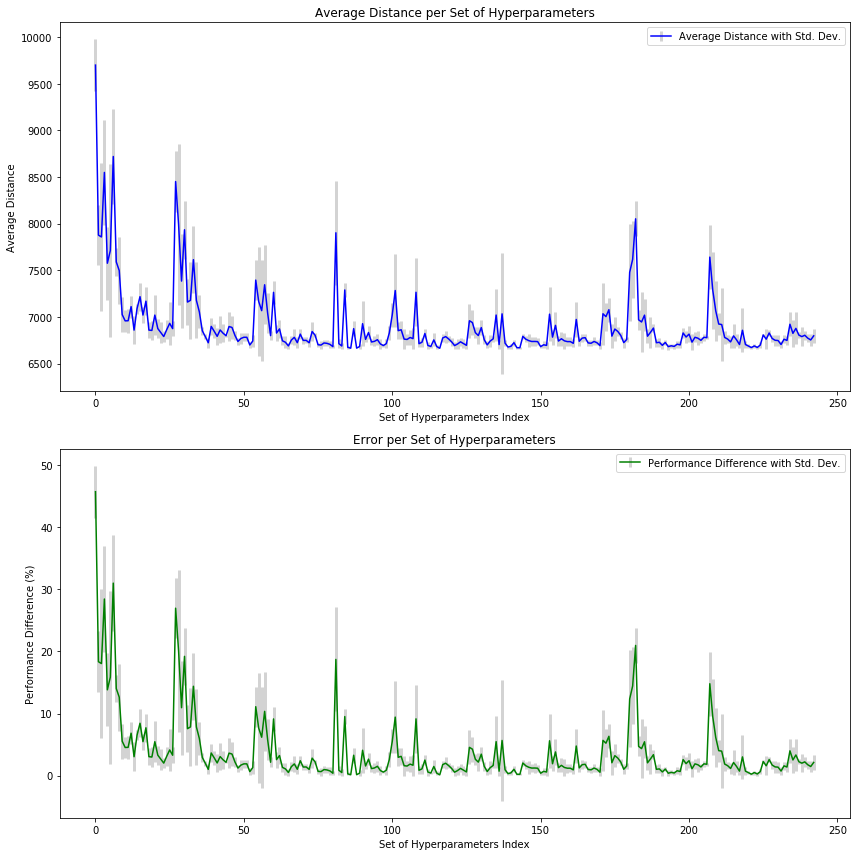

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store the metrics for plotting
avg_distances = []
std_dev_distances = []
avg_perf_diffs = []
std_dev_perf_diffs = []

# Read and parse the results from the file
with open('aco_tsp_hyperparameter_study_results.txt', 'r') as file:
    for line in file:
        # Splitting the line by commas, then parsing each part
        parts = line.split(',')
        avg_distance = float(parts[5].split(':')[1].strip())
        std_dev_distance = float(parts[6].split(':')[1].strip())
        avg_perf_diff = float(parts[7].split(':')[1].replace('%', '').strip())
        std_dev_perf_diff = float(parts[8].split(':')[1].replace('%', '').strip())
        
        # Append the parsed metrics to their respective lists
        avg_distances.append(avg_distance)
        std_dev_distances.append(std_dev_distance)
        avg_perf_diffs.append(avg_perf_diff)
        std_dev_perf_diffs.append(std_dev_perf_diff)

# Convert lists to numpy arrays for easier handling
avg_distances = np.array(avg_distances)
std_dev_distances = np.array(std_dev_distances)
avg_perf_diffs = np.array(avg_perf_diffs)
std_dev_perf_diffs = np.array(std_dev_perf_diffs)

# Plotting the metrics
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot 1: Average Distance per Set of Hyperparameters
axs[0].errorbar(range(len(avg_distances)), avg_distances, yerr=std_dev_distances, color='blue', ecolor='lightgray', elinewidth=3, capsize=0, label='Average Distance with Std. Dev.')
axs[0].set_title('Average Distance per Set of Hyperparameters')
axs[0].set_xlabel('Set of Hyperparameters Index')
axs[0].set_ylabel('Average Distance')
axs[0].legend()

# Plot 2: Performance Difference per Set of Hyperparameters
axs[1].errorbar(range(len(avg_perf_diffs)), avg_perf_diffs, yerr=std_dev_perf_diffs, color='green', ecolor='lightgray', elinewidth=3, capsize=0, label='Performance Difference with Std. Dev.')
axs[1].set_title('Error per Set of Hyperparameters')
axs[1].set_xlabel('Set of Hyperparameters Index')
axs[1].set_ylabel('Performance Difference (%)')
axs[1].legend()

plt.tight_layout()
plt.show()


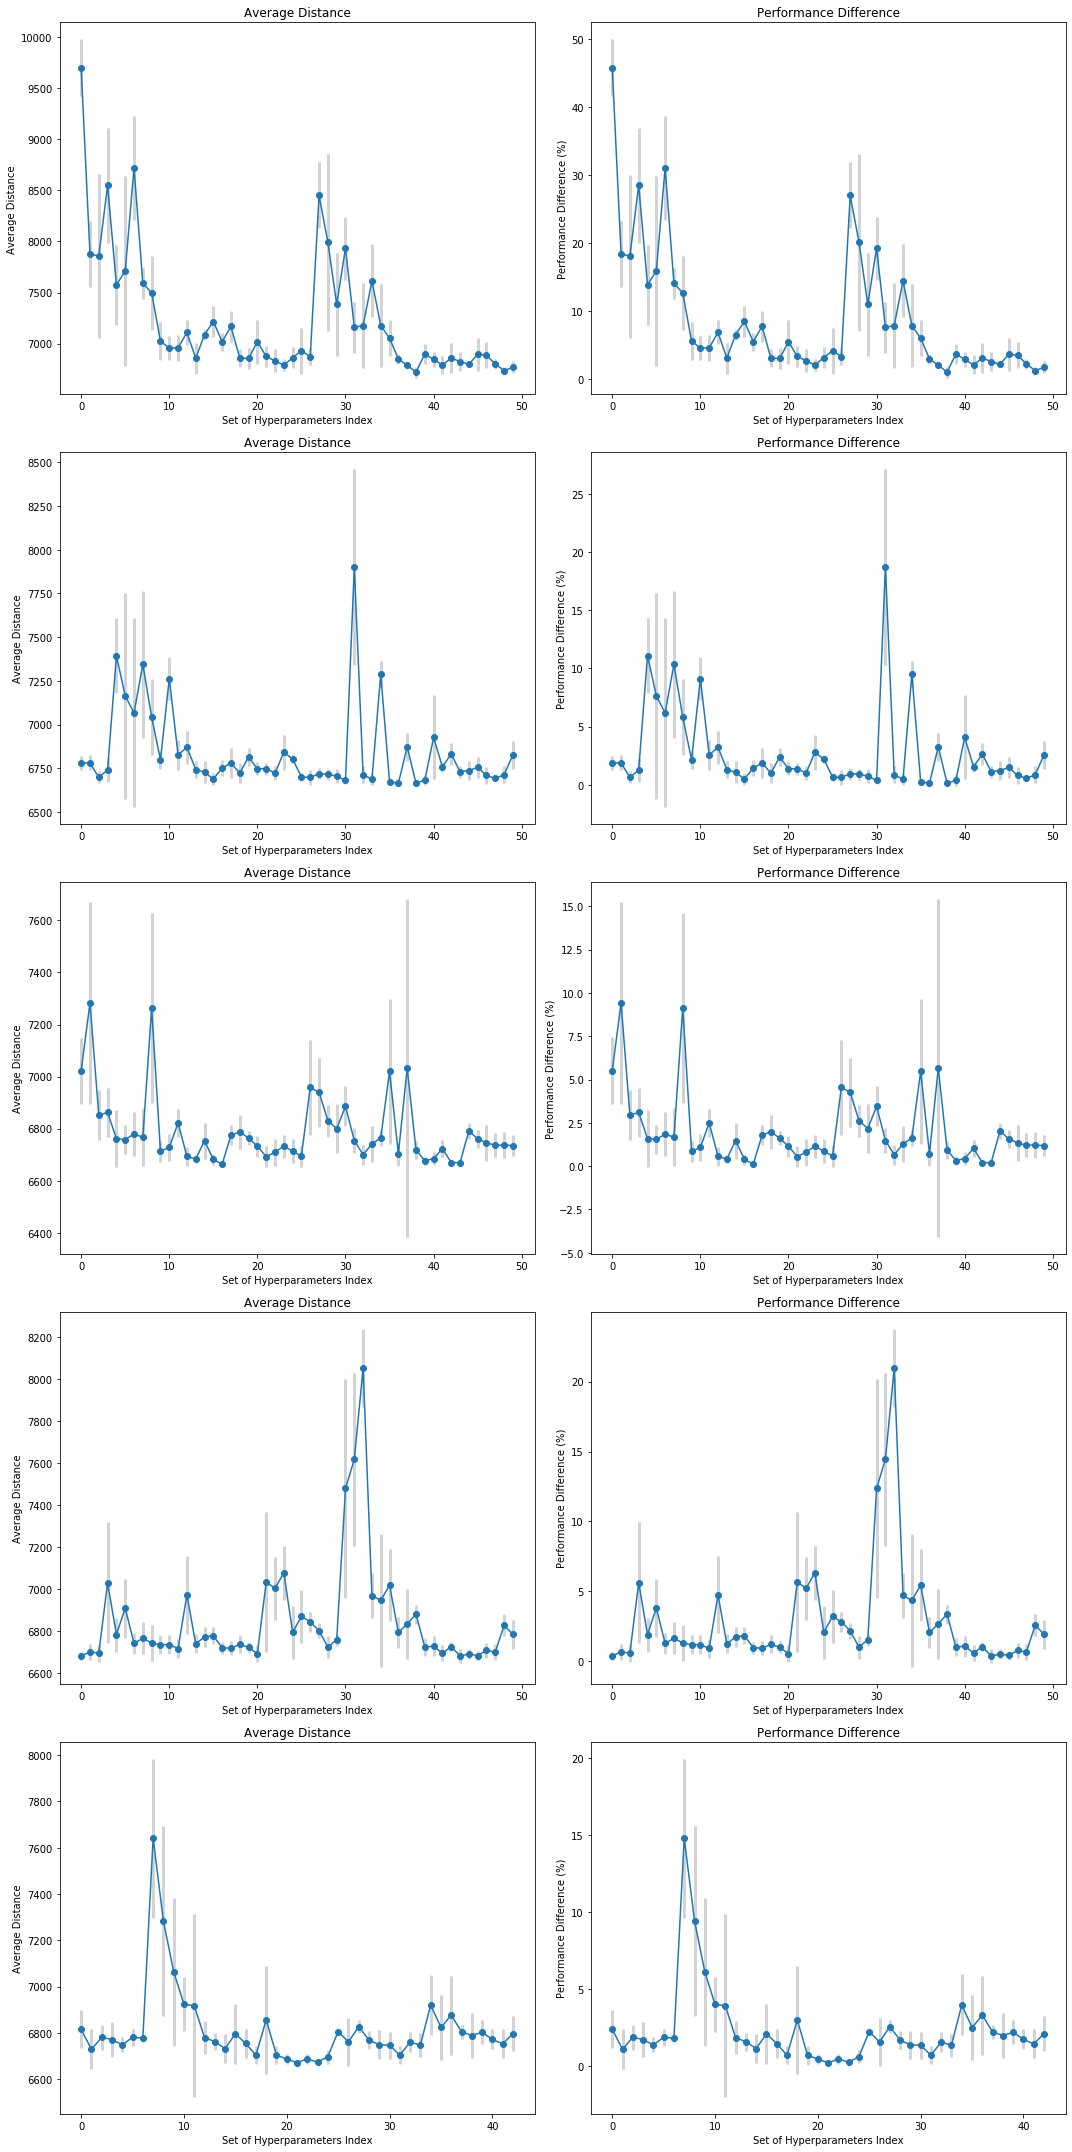

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming avg_distances, std_dev_distances, avg_perf_diffs, std_dev_perf_diffs are already populated as numpy arrays
# Define the number of plots based on the chunk size
chunk_size = 50
num_plots = int(np.ceil(len(avg_distances) / chunk_size))

fig, axs = plt.subplots(num_plots, 2, figsize=(15, num_plots * 6))  # 2 columns for two metrics

# Function to plot a single metric
def plot_metric(ax, data, yerr, title, ylabel):
    indices = range(len(data))
    ax.errorbar(indices, data, yerr=yerr, fmt='-o', ecolor='lightgray', elinewidth=3, capsize=0)
    ax.set_title(title)
    ax.set_xlabel('Set of Hyperparameters Index')
    ax.set_ylabel(ylabel)

# Plot each chunk
for i in range(num_plots):
    # Determine the start and end index for each chunk
    start_idx = i * chunk_size
    end_idx = start_idx + chunk_size

    # Slicing the data for this chunk
    distances_chunk = avg_distances[start_idx:end_idx]
    distances_err_chunk = std_dev_distances[start_idx:end_idx]
    perf_diff_chunk = avg_perf_diffs[start_idx:end_idx]
    perf_diff_err_chunk = std_dev_perf_diffs[start_idx:end_idx]

    # Plotting average distances
    ax_distance = axs[i, 0] if num_plots > 1 else axs[0]
    plot_metric(ax_distance, distances_chunk, distances_err_chunk, 'Average Distance', 'Average Distance')

    # Plotting performance differences
    ax_perf_diff = axs[i, 1] if num_plots > 1 else axs[1]
    plot_metric(ax_perf_diff, perf_diff_chunk, perf_diff_err_chunk, 'Performance Difference', 'Performance Difference (%)')

plt.tight_layout()
plt.show()


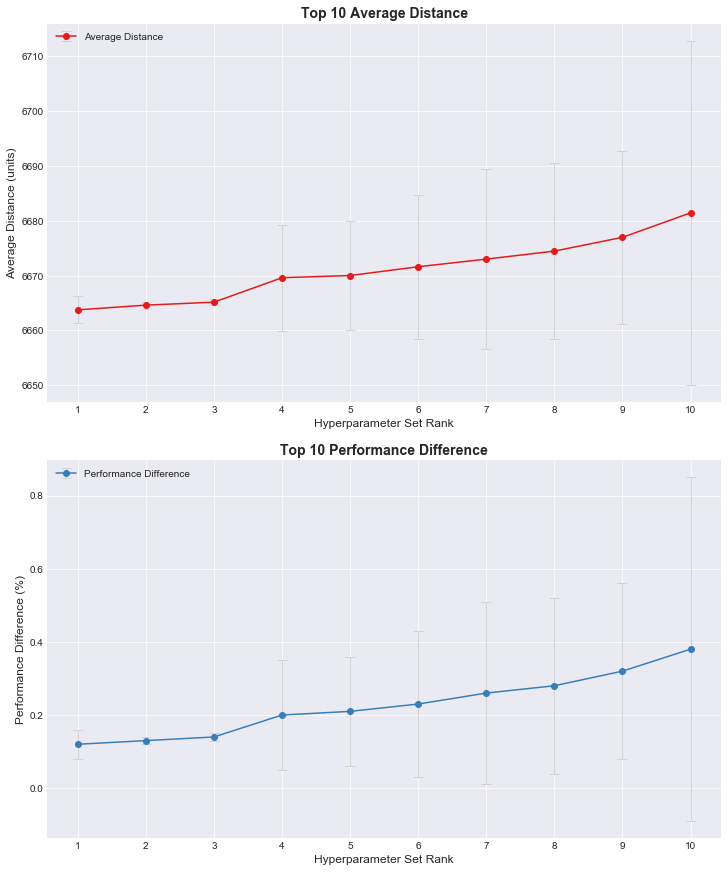

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create a structured array for easier sorting
structured_data = np.core.records.fromarrays(
    [avg_distances, std_dev_distances, avg_perf_diffs, std_dev_perf_diffs],
    names='avg_distance, std_dev_distance, avg_perf_diff, std_dev_perf_diff'
)

# Sort by average performance difference in ascending order to get the best (smallest) values
sorted_data = np.sort(structured_data, order='avg_perf_diff')

# Select the top 10
top_10_data = sorted_data[:10]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming top_10_data is already defined as structured numpy array with necessary data
# Setup for more professional-looking plots
plt.style.use('seaborn-darkgrid')  # Use a nice style for the plot
palette = plt.get_cmap('Set1')  # Get a set of colors from matplotlib's predefined palettes

fig, axs = plt.subplots(2, 1, figsize=(10, 12), constrained_layout=True)

# Error bars can sometimes be more visually striking if they are thinner or lighter than the main data line
error_kw = {'elinewidth': 1, 'capsize': 5, 'capthick': 1, 'ecolor': 'lightgray'}

# Plot 1: Top 10 Average Distance
axs[0].errorbar(range(1, 11), top_10_data['avg_distance'], yerr=top_10_data['std_dev_distance'], fmt='-o', 
                color=palette(0), ecolor=error_kw['ecolor'], elinewidth=error_kw['elinewidth'],
                capsize=error_kw['capsize'], capthick=error_kw['capthick'], label='Average Distance')
axs[0].set_title('Top 10 Average Distance', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Hyperparameter Set Rank', fontsize=12)
axs[0].set_ylabel('Average Distance (units)', fontsize=12)
axs[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axs[0].legend()

# Plot 2: Top 10 Performance Difference
axs[1].errorbar(range(1, 11), top_10_data['avg_perf_diff'], yerr=top_10_data['std_dev_perf_diff'], fmt='-o', 
                color=palette(1), ecolor=error_kw['ecolor'], elinewidth=error_kw['elinewidth'],
                capsize=error_kw['capsize'], capthick=error_kw['capthick'], label='Performance Difference')
axs[1].set_title('Top 10 Performance Difference', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Hyperparameter Set Rank', fontsize=12)
axs[1].set_ylabel('Performance Difference (%)', fontsize=12)
axs[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axs[1].legend()

# Show the plot with a tight layout to ensure no overlapping text/labels
plt.show()


In [42]:
def read_hyperparameter_results(file_path):
    results = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split(',')
            hyperparams = {
                'num_ants': int(parts[0].split(':')[1].strip()),
                'num_iterations': int(parts[1].split(':')[1].strip()),
                'alpha': float(parts[2].split(':')[1].strip()),
                'beta': float(parts[3].split(':')[1].strip()),
                'decay': float(parts[4].split(':')[1].strip()),
                'avg_distance': float(parts[5].split(':')[1].strip()),
                'std_dev_distance': float(parts[6].split(':')[1].strip()),
                # Remove '%' and convert to float
                'avg_perf_diff': float(parts[7].split(':')[1].strip().replace('%', '')),
                'std_dev_perf_diff': float(parts[8].split(':')[1].strip().replace('%', ''))
            }
            results.append(hyperparams)
    # Sort by Average Performance Difference in ascending order
    sorted_results = sorted(results, key=lambda x: x['avg_perf_diff'])
    return sorted_results[:5]  # Return top 5

top_hyperparameters = read_hyperparameter_results('aco_tsp_hyperparameter_study_results.txt')



In [43]:
print(top_hyperparameters)

[{'num_ants': 30, 'num_iterations': 150, 'alpha': 1.0, 'beta': 2.5, 'decay': 0.1, 'avg_distance': 6663.76, 'std_dev_distance': 2.44, 'avg_perf_diff': 0.12, 'std_dev_perf_diff': 0.04}, {'num_ants': 20, 'num_iterations': 150, 'alpha': 1.0, 'beta': 2.0, 'decay': 0.1, 'avg_distance': 6664.62, 'std_dev_distance': 0.62, 'avg_perf_diff': 0.13, 'std_dev_perf_diff': 0.01}, {'num_ants': 30, 'num_iterations': 100, 'alpha': 1.0, 'beta': 2.0, 'decay': 0.1, 'avg_distance': 6665.16, 'std_dev_distance': 0.53, 'avg_perf_diff': 0.14, 'std_dev_perf_diff': 0.01}, {'num_ants': 30, 'num_iterations': 150, 'alpha': 1.0, 'beta': 3.0, 'decay': 0.1, 'avg_distance': 6669.62, 'std_dev_distance': 9.67, 'avg_perf_diff': 0.2, 'std_dev_perf_diff': 0.15}, {'num_ants': 30, 'num_iterations': 100, 'alpha': 1.0, 'beta': 3.0, 'decay': 0.1, 'avg_distance': 6670.02, 'std_dev_distance': 9.93, 'avg_perf_diff': 0.21, 'std_dev_perf_diff': 0.15}]


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Assuming the ACO class/function and the 'cities' array are defined as before
# Also assuming 'distance_matrix' is predefined and corresponds to 'cities'

# The top 5 hyperparameters from your results
top_hyperparameters = [
    {'num_ants': 30, 'num_iterations': 150, 'alpha': 1.0, 'beta': 2.5, 'decay': 0.1},
    {'num_ants': 20, 'num_iterations': 150, 'alpha': 1.0, 'beta': 2.0, 'decay': 0.1},
    {'num_ants': 30, 'num_iterations': 100, 'alpha': 1.0, 'beta': 2.0, 'decay': 0.1},
    {'num_ants': 30, 'num_iterations': 150, 'alpha': 1.0, 'beta': 3.0, 'decay': 0.1},
    {'num_ants': 30, 'num_iterations': 100, 'alpha': 1.0, 'beta': 3.0, 'decay': 0.1}
]

def run_aco_with_hyperparameters(hyperparameters):
    # Initialize and run the ACO algorithm
    aco = ACO(distance_matrix=distance_matrix,
              num_ants=hyperparameters['num_ants'],
              num_iterations=hyperparameters['num_iterations'],
              decay=hyperparameters['decay'],
              alpha=hyperparameters['alpha'],
              beta=hyperparameters['beta'])
    best_route, best_distance = aco.run()

    # Assuming the ACO class tracks the best distance at each iteration
    convergence_speed = np.argmin(aco.best_distance_history) + 1  # +1 since indexing starts at 0

    return {
        'best_distance': best_distance,
        'convergence_speed': convergence_speed,
        'best_distance_history': aco.best_distance_history  # To analyze and plot later
    }

# Run in-depth analysis for each set of hyperparameters
analysis_results = []
for params in top_hyperparameters:
    start_time = time.time()
    result = run_aco_with_hyperparameters(params)
    end_time = time.time()
    duration = end_time - start_time
    result['execution_time'] = duration
    analysis_results.append(result)

# Example of printing the analysis results
for i, result in enumerate(analysis_results, start=1):
    print(f"Set {i}: Best Distance: {result['best_distance']}, Convergence Speed: {result['convergence_speed']}, Execution Time: {result['execution_time']}s")

# You can add more detailed analysis, plots, and comparisons here as needed.


Stopping early due to stagnation after 97 iterations.
Stopping early due to stagnation after 106 iterations.
Stopping early due to stagnation after 73 iterations.
Stopping early due to stagnation after 73 iterations.
Set 1: Best Distance: 6663.213801224397, Convergence Speed: 68, Execution Time: 13.102090835571289s
Set 2: Best Distance: 6664.113570564627, Convergence Speed: 77, Execution Time: 9.486205101013184s
Set 3: Best Distance: 6664.113570564627, Convergence Speed: 99, Execution Time: 13.744440793991089s
Set 4: Best Distance: 6665.571239808189, Convergence Speed: 44, Execution Time: 9.775716781616211s
Set 5: Best Distance: 6697.887398526848, Convergence Speed: 44, Execution Time: 9.05315113067627s
